In [1]:
import io
import sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob
import copy
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp, retEEGexp

In [4]:
%matplotlib notebook

## EEGexp class

In [5]:
# rec_folder = r'E:\eeg_pilot\mouse000000\estim_vis_test_2020-09-10\experiment1\recording1' # this is the test
rec_folder = r'B:\mouse598180\pilot4_ext_ref_2021-10-21_11-43-48\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation


In [6]:
print(exp.mouse)
print(exp.experiment_type)
print(exp.stim_instruction_files)
print(exp.stimulus_log_file)

598180
electrical stimulation
{'sensory': [], 'electrical': ['B:\\mouse598180\\pilot4_ext_ref_2021-10-21_11-43-48\\experiment1\\recording1\\sine_8-28-140-500-1000-5000Hz_5-1uA_stim_protocol.dat', 'B:\\mouse598180\\pilot4_ext_ref_2021-10-21_11-43-48\\experiment1\\recording1\\sine_8-28-140-500-1000-5000Hz_5-1uA_stim_protocol.stm'], 'opto': []}
B:\mouse598180\pilot4_ext_ref_2021-10-21_11-43-48\experiment1\recording1\estim_log.csv


In [7]:
sync_data = exp._load_sync_dataset()
print(sync_data.line_labels)

['barcodes', 'opto_copy', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


## Electrical stim - sine wave

In [8]:
esweep_rising = sync_data.get_edges(keys=('estim_sweep',), kind='rising', units='seconds')
esweep_falling = sync_data.get_edges(keys=('estim_sweep',), kind='falling', units='seconds')
esync_rising = sync_data.get_edges(keys=('estim_sync',), kind='rising', units='seconds')
esync_falling = sync_data.get_edges(keys=('estim_sync',), kind='falling', units='seconds')

In [9]:
total_trials = len(esync_rising)
print('Total e-stim trials: %d' % total_trials)
num_sweeps = len(esweep_rising)
print('Number of e-stim sweeps: %d' % num_sweeps)
trials_per_sweep = int(total_trials / num_sweeps)
print('Trials per sweep: %d' % trials_per_sweep)

Total e-stim trials: 90
Number of e-stim sweeps: 1
Trials per sweep: 90


### This reads the stim_protocol.dat file and extracts the signal we delivered.

In [10]:
with open(exp.stim_instruction_files['electrical'][0]) as file:
    estim_txt = file.read() # open estim file and read in text
estim = estim_txt.split('channel:') # split and read txt file
d = {}
for item in estim:
    if 'value' in item:
        key = 'channel'+str(item[1])
        d[key]=item.split('\n')
channel1 = d['channel1'][1:]
ch1_df = pd.read_csv(io.StringIO('\n'.join(channel1)), delim_whitespace=True)
channel3 = d['channel3'][1:]
ch3_df = pd.read_csv(io.StringIO('\n'.join(channel3)), delim_whitespace=True)

In [12]:
estim[1][:40]

' 1\n\nvalue\ttime\n0\t300000000\n0\t40\n0.2\t40\n0'

In [14]:
ch1_df.tail()

,value,time
7555612,-0.6,20.0
7555613,-1.2,20.0
7555614,-1.8,20.0
7555615,-2.4,20.0
7555616,-3.0,NaN


In [11]:
ch1_df['timestamps'] = ch1_df.time.cumsum()
# ch1_df.head()
ch3_df['timestamps'] = ch3_df.time.cumsum()
# ch3_df.head()

The actual signal is in "channel 1" and the sync signal is in "channel 3" in the dat file.

In [12]:
stim_signal = ch1_df['value'].values
signal_ts = ch1_df['timestamps'].values
sync = ch3_df['value'].values
sync_ts = ch3_df['timestamps'].values

This plots the stim_protocol signals, just to check if it looks right. Signal is blue, sync signal is orange.

<IPython.core.display.Javascript object>


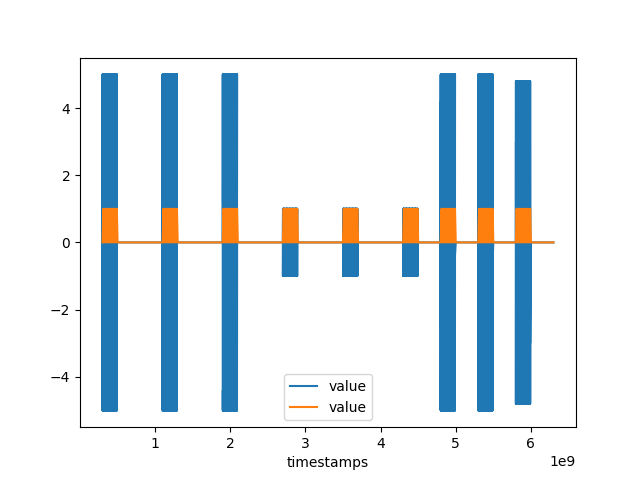

In [13]:
fig, ax = plt.subplots()

ch1_df.plot(x='timestamps', y='value', ax=ax);
ch3_df.plot(x='timestamps', y='value', ax=ax);

This loops through the sync pulses, and counts the peaks in the signal to define the frequency of the sine wave (and the amplitude).

In [14]:
list_stim_type = []
list_stim_amp = []
list_stim_dur = []
for i in range(len(sync)):
    if sync[i] == 1:
        start = sync_ts[i-1]
        end = sync_ts[i]
        siginds = np.squeeze(np.argwhere((signal_ts >= start) & (signal_ts <= end)))
        sine_pulse = stim_signal[siginds]
        ## amplitude ##
        list_stim_amp.append(int(np.max(sine_pulse)))
        ## frequency ##
        peaks, _ = signal.find_peaks(sine_pulse, height=np.max(sine_pulse)-0.5)
        freq = int(np.round(len(peaks) / ((end - start) * 1E-6)))
        list_stim_type.append('sine_' + str(freq) + 'Hz')

Put that info into a dataframe

In [15]:
estim_sine_log = pd.DataFrame({
    'stim_type': list_stim_type,
    'parameter': list_stim_amp,
})
print(len(estim_sine_log))
estim_sine_log.head()

90


,stim_type,parameter
0,sine_140Hz,5
1,sine_140Hz,5
2,sine_140Hz,5
3,sine_140Hz,5
4,sine_140Hz,5


In [16]:
estim_sine_log.tail()

,stim_type,parameter
85,sine_5000Hz,4
86,sine_5000Hz,4
87,sine_5000Hz,4
88,sine_5000Hz,4
89,sine_5000Hz,4


Make sure the length matches the number of pulses recorded by the sync computer.

In [89]:
if len(estim_sine_log) == trials_per_sweep:
    estim_sine_log = pd.concat([estim_sine_log] * num_sweeps, axis='index', ignore_index=True)
else:
    print('estim_log does not match total_trials / num_sweeps')

Add onset, offset, and durations to each line in the dataframe. This part only works if the number of sync pulses matches the number of stims delivered according to the stim_protocol.dat file.

In [90]:
estim_sine_log['onset'] = esync_rising
estim_sine_log['offset'] = esync_falling
estim_sine_log['duration'] = estim_sine_log['offset'] - estim_sine_log['onset']

In [92]:
estim_sine_log['sweep'] = np.zeros(len(estim_sine_log), dtype=int) - 1
for i in range(len(esweep_rising)):
    # print('Sweep %d: %f to %f' % (i, sweep_start, sweep_end))
    estim_sine_log.loc[(estim_sine_log['onset'] >= esweep_rising[i]) & (estim_sine_log['onset'] <= esweep_falling[i]), 'sweep'] = i

In [93]:
estim_sine_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,sine_140Hz,5,349.63525,359.63131,9.99606,0
1,sine_140Hz,5,369.63136,379.62742,9.99606,0
2,sine_140Hz,5,389.62747,399.62353,9.99606,0
3,sine_140Hz,5,409.62358,419.61964,9.99606,0
4,sine_140Hz,5,429.61969,439.61574,9.99605,0


### Save the dataframe as the log file

In [94]:
estim_sine_log.to_csv(exp.stimulus_log_file, index=False)

# Ignore the rest for now, it will be useful if we decide to deliver sine stim and visual stim together some day.

## Sensory stim

This is from NP4 with a digital photodiode.<br>Load behavior_sweep, behavior_sync, and photodiode rising and falling edges.

Load 'timestamp'_stimulus_log.csv

Remove "gray" screens from log

Correct onset and offset times using photodiode rising and falling times

## Opto stim

#### Get opto onset times from sync data

print(opto_trial_falling - opto_trial_rising)
<br> The rising/falling edges here do not capture the actual duration of each stimulus.

#### Read opto.pkl file

Make a dict to define the conditions

Create the opto stim log

Add sweep number

## Combine logs into all_stim_log, sorted by onset times.

## Save file to test whether index matters...

### Load file to see index

Hmm...combining the logs forces the amplitude to be a string...